In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import robotdatapy as rdp # 1.0.3
import scipy as sp

# plt.style.use('/home/masonbp/computer/python/matplotlib/publication.mplstyle')
SAVE = True
QUICK = False
ADD_ANNOTATIONS = True

# quicker
if QUICK:
    num_pcs = 100
    num_markers = 500
else:
    num_pcs = 3000
    num_markers = 4000

In [2]:
def get_pc(bag_path, topic, child_frame):
    pcd = rdp.data.PointCloudData.from_bag(
        path=bag_path,
        topic=topic,
    )

    marker_data = rdp.data.GeneralData.from_bag(
        path=bag_path,
        topic="/NX01/actual_traj",
        ros_distro='humble',
        time_tol=30.0,
        causal=False
    )

    pc_frame = pcd.msg_header(pcd.t0).frame_id
    print("pc_frame:", pc_frame)

    pd = rdp.data.PoseData.from_bag_tf(
        bag_path,
        parent_frame="map",
        child_frame=child_frame,
        time_tol=30.0
    )

    # Robust point cloud extraction at pcd.tf
    pc = pcd.pointcloud(pcd.tf).get_xyz()
    # if not isinstance(vecs, np.ndarray) or vecs.ndim != 2 or vecs.shape[0] == 0 or vecs.shape[1] != 3:
    #     print(f"[Warning] Empty or invalid point cloud at t = {pcd.tf}. Skipping transform.")
    #     pc = np.zeros((0, 3))
    # else:
    #     pc = rdp.transform.transform(pd.pose(pcd.tf), vecs)

    return pc, pcd, pd, marker_data

def apply_transform(points):
    T_side_view = rdp.transform.xyz_rpy_to_transform([0., 0., 0.], [-85., -0., 0.], degrees=True) @ \
        rdp.transform.xyz_rpy_to_transform([0., 0., 0.,], [0., 0., 80.], degrees=True)
    # T_side_view = np.eye(4)

    # degrees to rotation matrix
    roll = 180
    pitch = 0
    yaw = 0

    rotation_matrix = sp.spatial.transform.Rotation.from_euler('xyz', [roll, pitch, yaw], degrees=True).as_matrix()
    T_world_cam = np.array([
        [1., 0., 0., 60.,],
        [0., -1., 0., 0.,],
        [0., 0., -1., 175.,],
        [0., 0., 0., 1.,]
    ])

    K = np.array([[300, 0., 0.], [0., 300, 0.], [0., 0., 1.]])

    points_cam = rdp.transform.transform(np.linalg.inv(T_world_cam) @ T_side_view, points)
    points_cam = points_cam[points_cam[:,2] > 0.1]
    points_side_view = rdp.camera.xyz_2_pixel(points_cam, K)
    return points_side_view

def plot_pc(pc, pcd, pd, marker_data, bag_path, figure_name):
    import matplotlib.pyplot as plt
    plt.style.use('dark_background')
    t = np.linspace(pcd.t0, pcd.tf, num_pcs)

    pcs = []
    for ti in t:
        vecs = pcd.pointcloud(ti).get_xyz()
        if vecs.ndim != 2 or vecs.shape[0] == 0 or vecs.shape[1] != 3:
            print(f"[Warning] Skipping invalid point cloud at t = {ti}. Shape = {vecs.shape}")
            continue
        pc = vecs
        # pc = rdp.transform.transform(pd.pose(ti), vecs)
        pcs.append(pc)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 10), dpi=500)

    if len(pcs) == 0:
        print("[Warning] No valid point clouds found. Skipping point cloud plot.")
        pc = np.zeros((0, 3))  # Fallback
        ax.text(0.5, 0.5, 'No valid point cloud data', transform=ax.transAxes,
                ha='center', va='center', color='white', fontsize=16)
    else:
        pc = np.vstack(pcs)
        ax.plot(pc[:, 0], pc[:, 1], '.', markersize=0.15, alpha=0.2, color='xkcd:white')

        # --- Compute and add a 10 m scale bar ---
        # x_min, x_max = np.min(pc[:, 0]), np.max(pc[:, 0])
        # y_min, y_max = np.min(pc[:, 1]), np.max(pc[:, 1])
        # print("x_min, x_max, y_min, y_max:", x_min, x_max, y_min, y_max)

        # x_pad = 0.05 * (x_max - x_min)
        # y_pad = 0.05 * (y_max - y_min)
        # x_scale_start = x_min + x_pad - 30.0
        # x_scale_end = x_scale_start + 10.0  # 10 meters
        # y_scale = y_max - y_pad + 20.0

        # ax.plot([x_scale_start, x_scale_end], [y_scale, y_scale], color='white', linewidth=1.5)
        # ax.plot([x_scale_start, x_scale_start], [y_scale - 0.5, y_scale + 0.5], color='white', linewidth=0.5)
        # ax.plot([x_scale_end, x_scale_end], [y_scale - 0.5, y_scale + 0.5], color='white', linewidth=0.5)
        # ax.text(x_scale_start, y_scale - 4.5, '10 m', color='white', fontsize=16)

    # --- Plot markers ---
    marker_xyz = []
    marker_colors = []
    for ti in np.linspace(marker_data.t0, marker_data.tf, num_markers):
        position_ros = marker_data.data(ti).pose.position
        color_ros = marker_data.data(ti).color
        mi = np.array([position_ros.x, position_ros.y, position_ros.z])
        marker_xyz.append(rdp.transform.transform(pd.pose(ti), mi))
        marker_colors.append([color_ros.r, color_ros.g, color_ros.b])
    marker_xyz = np.array(marker_xyz)
    marker_colors = np.array(marker_colors)

    for i in range(marker_xyz.shape[0]):
        ax.plot(marker_xyz[i, 0], marker_xyz[i, 1], '.', markersize=1.0, alpha=1.0, color=marker_colors[i])

    # --- Annotations ---
    if ADD_ANNOTATIONS and len(marker_xyz) > 0:
        markersize = 15.0
        bbox_props = dict(facecolor='white', boxstyle='round,pad=0.1')
        ax.plot([marker_xyz[0, 0]], [marker_xyz[0, 1]], '.', markersize=markersize, color='xkcd:red')
        ax.plot([marker_xyz[-1, 0]], [marker_xyz[-1, 1]], '.', markersize=markersize, color='xkcd:blue')
        ax.text(marker_xyz[0, 0] - 30.0, marker_xyz[0, 1] - 1, 'Start', color='red', fontsize=16, bbox=bbox_props)
        ax.text(marker_xyz[-1, 0] + 5.0, marker_xyz[-1, 1] - 1, 'Goal', color='blue', fontsize=16, bbox=bbox_props)

    ax.set_aspect('equal')
    ax.axis('off')

    if SAVE:
        folder_path = bag_path[:bag_path.rfind('/')]
        plt.savefig(folder_path + figure_name, bbox_inches='tight')

    return pc, marker_xyz, marker_colors

def plot_with_angle(pc, marker_xyz, marker_colors, bag_path, figure_name):
    fig, ax = plt.subplots(figsize=(10, 10), dpi=500)

    # Apply side view transform if point cloud is not empty
    if pc.shape[0] > 0:
        pc_side_view = apply_transform(pc)
        ax.plot(pc_side_view[:, 0], -pc_side_view[:, 1], '.', markersize=0.15, alpha=0.2, color='xkcd:white')
    else:
        print("[Warning] No point cloud data for side view. Skipping point cloud plot.")
        ax.text(0.5, 0.5, 'No point cloud', transform=ax.transAxes,
                ha='center', va='center', color='white', fontsize=16)

    # Apply side view transform to marker data if available
    if marker_xyz.shape[0] > 0:
        marker_xyz_side_view = apply_transform(marker_xyz)

        for i in range(marker_xyz_side_view.shape[0]):
            ax.plot(marker_xyz_side_view[i, 0], -marker_xyz_side_view[i, 1], '.',
                    markersize=1.0, alpha=1.0, color=marker_colors[i])

        if ADD_ANNOTATIONS:
            markersize = 10.0
            bbox = dict(facecolor='white', boxstyle='round,pad=0.1')
            # Plot start and goal markers
            ax.plot([marker_xyz_side_view[0, 0]], [-marker_xyz_side_view[0, 1]], '.', markersize=markersize, color='xkcd:red')
            ax.plot([marker_xyz_side_view[-1, 0]], [-marker_xyz_side_view[-1, 1]], '.', markersize=markersize, color='xkcd:blue')
            # Add labels
            ax.text(marker_xyz_side_view[0, 0] - 2, -marker_xyz_side_view[0, 1] + 3,
                    'Start', color='red', fontsize=16, bbox=bbox)
            ax.text(marker_xyz_side_view[-1, 0] - 3, -marker_xyz_side_view[-1, 1] - 5,
                    'Goal', color='blue', fontsize=16, bbox=bbox)
    else:
        print("[Warning] No marker data for side view.")

    ax.set_aspect('equal')
    ax.axis('off')

    if SAVE:
        folder_path = bag_path[:bag_path.rfind('/')]
        plt.savefig(folder_path + figure_name, bbox_inches='tight')


pc_frame: map
[Warning] Skipping invalid point cloud at t = 1758736697.6973357. Shape = (0,)
[Warning] Skipping invalid point cloud at t = 1758736697.7282808. Shape = (0,)
[Warning] Skipping invalid point cloud at t = 1758736697.7592256. Shape = (0,)
[Warning] Skipping invalid point cloud at t = 1758736697.7901707. Shape = (0,)
[Warning] Skipping invalid point cloud at t = 1758736697.8211157. Shape = (0,)
[Warning] Skipping invalid point cloud at t = 1758736697.8520606. Shape = (0,)
[Warning] Skipping invalid point cloud at t = 1758736697.8830056. Shape = (0,)
[Warning] Skipping invalid point cloud at t = 1758736697.9139507. Shape = (0,)
[Warning] Skipping invalid point cloud at t = 1758736697.9448957. Shape = (0,)
[Warning] Skipping invalid point cloud at t = 1758736697.9758406. Shape = (0,)
[Warning] Skipping invalid point cloud at t = 1758736698.0067856. Shape = (0,)
[Warning] Skipping invalid point cloud at t = 1758736698.0377307. Shape = (0,)
[Warning] Skipping invalid point cloud

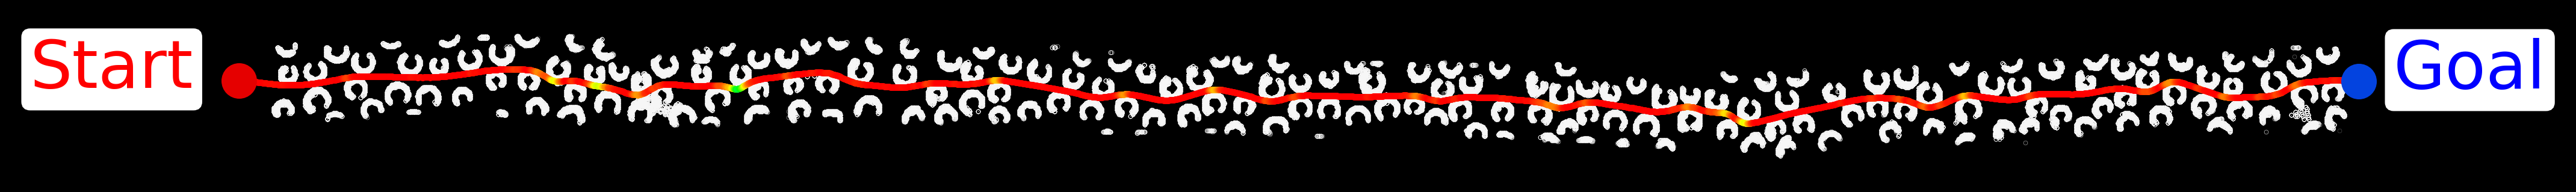

In [3]:
# plot the point cloud data
# topic = "/NX01/mid360_PointCloud2"
topic = "/NX01/occupancy_grid"
bag_num = "num_1"

bag_path = f"/media/kkondo/kota_elements/mighty/static/hard_forest/unconstrained/bags/mighty/{bag_num}"
pc, pcd, pd, marker_data = get_pc(bag_path, topic, child_frame="NX01/NX01_livox")

paper_path = "/home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/hard_forest/"
pc, marker_xyz, marker_colors = plot_pc(pc, pcd, pd, marker_data, paper_path, f"/static_{bag_num}_overhead_pc.png")
# plot_with_angle(pc, marker_xyz, marker_colors, paper_path, f"/static_{bag_num}_side_view_pc.png")

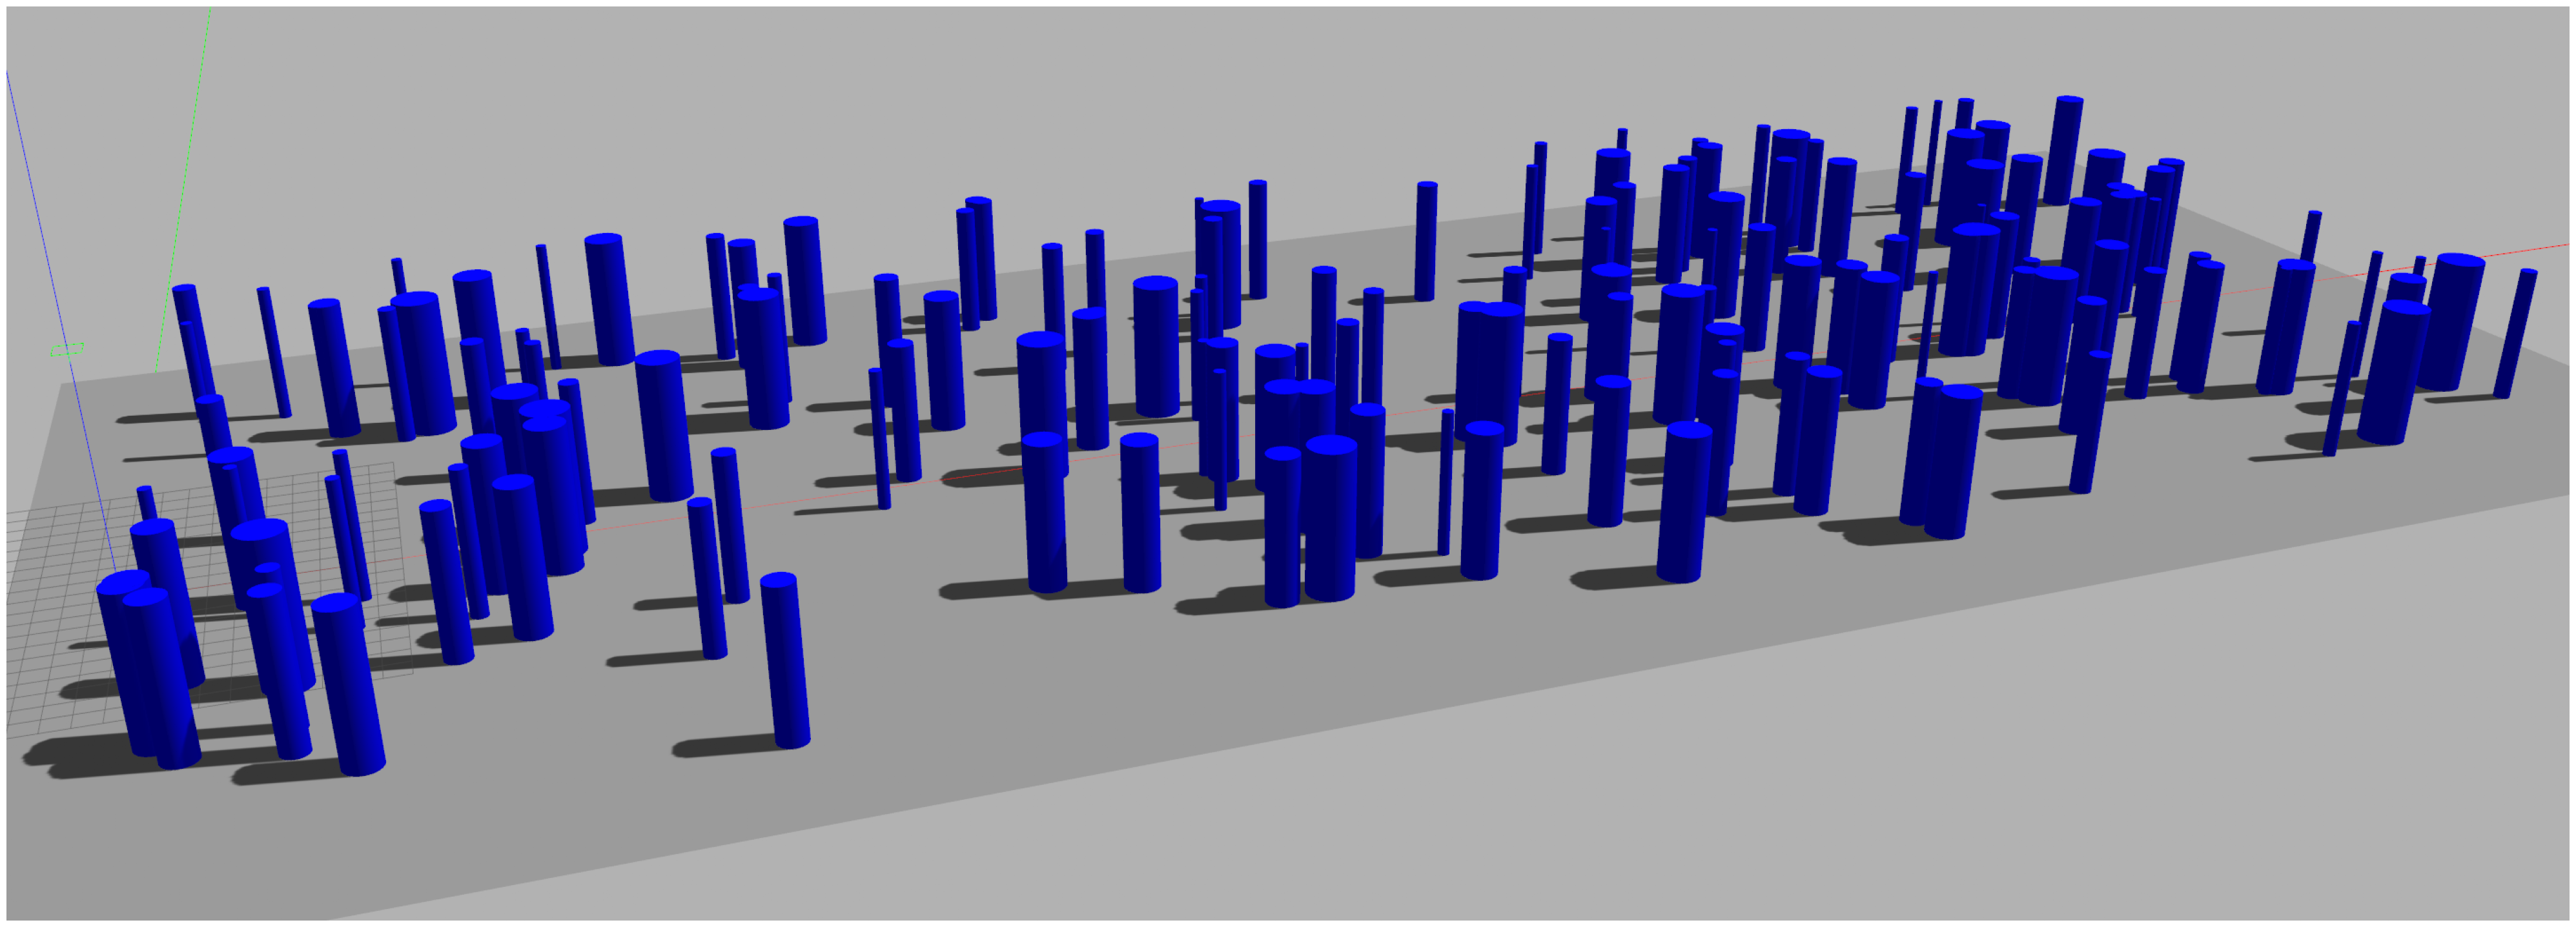

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import patheffects as pe

plt.style.use('default')

# ---------------- User setting: image scale ----------------
# How many pixels correspond to 1 meter in this Gazebo top-down image?
PIXELS_PER_METER = 35.0   # <-- adjust to your image's scale

# Load images
folder_path = "/media/kkondo/kota_elements/mighty/benchmark/hard_forest"
gazebo_image = plt.imread(folder_path + '/hard_forest_gazebo.png')

# Create a figure
fig_size_x = 40
fig_size_y = fig_size_x / 2.5
fig = plt.figure(figsize=(fig_size_x, fig_size_y))

# Crop the image (unchanged)
gazebo_image = gazebo_image[200:gazebo_image.shape[0] - 200,
                            400:gazebo_image.shape[1] - 100]

# Show the image
ax_gazebo = fig.add_subplot(1, 1, 1)
im = ax_gazebo.imshow(gazebo_image)  # origin='upper' by default (top-left is (0,0))
ax_gazebo.axis('off')

# ---------------- Add a 10 m scale bar (top-left) ----------------
h, w = gazebo_image.shape[:2]

# Bar config
bar_meters = 10.0
bar_px = bar_meters * PIXELS_PER_METER

# Margins from edges in pixels
left_pad_px = int(0.03 * w)
top_pad_px  = int(0.06 * h)

# If it doesn't fit, shrink to fit and update the text to the actual meters
if bar_px > (w - 2 * left_pad_px):
    bar_px = (w - 2 * left_pad_px)
    bar_meters = bar_px / PIXELS_PER_METER

x0 = left_pad_px
x1 = x0 + bar_px / 2.5 # i just change this number to fit the bar in the image
y  = top_pad_px

tick_h = max(6, int(0.015 * h))  # end tick height in px

# White stroke with black outline to ensure visibility
stroke = [pe.withStroke(linewidth=5, foreground='black')]

ax_gazebo.plot([x0, x1], [y, y], color='black', linewidth=3, solid_capstyle='butt', zorder=5)
ax_gazebo.plot([x0, x0], [y - tick_h/2, y + tick_h/2], color='black', linewidth=2, zorder=5)
ax_gazebo.plot([x1, x1], [y - tick_h/2, y + tick_h/2], color='black', linewidth=2, zorder=5)

# Label just below the bar
ax_gazebo.text(x0, y + tick_h + 10, f'{bar_meters:.0f} m', color='black', fontsize=60, va='top')

plt.tight_layout()

# Save
plt.savefig("/media/kkondo/kota_elements/mighty/benchmark/hard_forest/hard_forest_gazebo_trimmed.png",
            bbox_inches='tight', dpi=300)
plt.savefig("/home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/hard_forest/hard_forest_gazebo_trimmed.png",
            bbox_inches='tight', dpi=300)
